In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,KFold
from xgboost import XGBClassifier
import lightgbm as lgb
from rfpimp import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,classification_report
from collections import defaultdict
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import seaborn as sns
pd.set_option('display.max_rows',2000)

/home/arya/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_sub = pd.read_excel('Sample_Submission.xlsx')

In [3]:
df_train.describe()

,Freq_Of_Word_1,Freq_Of_Word_2,Freq_Of_Word_3,Freq_Of_Word_4,Freq_Of_Word_5,Freq_Of_Word_6,Freq_Of_Word_7,Freq_Of_Word_8,Freq_Of_Word_9,Freq_Of_Word_10,...,Freq_Of_Word_45,Freq_Of_Word_46,Freq_Of_Word_47,Freq_Of_Word_48,Freq_Of_Word_49,Freq_Of_Word_50,TotalEmojiCharacters,LengthOFFirstParagraph,StylizedLetters,IsGoodNews
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,...,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,0.023323,0.039056,0.020516,0.013038,-0.018424,0.002831,-0.006407,0.008428,0.044759,0.005193,...,0.059328,-0.005919,-0.031999,-0.001397,0.033669,0.013292,-0.013279,-0.021817,0.018881,0.388596
std,1.104679,1.085628,1.026794,1.345090,0.890268,0.970823,0.868676,1.136686,1.179691,1.129019,...,1.169027,0.959135,0.643179,0.821608,1.146482,0.860000,0.958807,0.513887,0.997459,0.487689
min,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.219003,-0.427682,0.000000
25%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.195476,-0.374323,0.000000
50%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.230681,-0.081172,-0.164107,-0.277435,0.000000
75%,-0.351864,-0.318036,0.326735,-0.039223,0.107252,-0.353977,-0.304257,-0.240708,-0.318797,-0.080193,...,-0.018022,-0.205212,-0.079531,-0.118688,-0.151911,0.145162,-0.054961,-0.038632,-0.039427,1.000000
max,13.771711,11.065546,9.184940,40.442907,8.479498,11.570173,6.461416,25.215295,18.826505,25.078049,...,18.446001,14.997385,13.943676,15.030734,15.146785,15.670854,28.750489,8.419193,12.437402,1.000000


In [4]:
df_test.describe()

,Freq_Of_Word_1,Freq_Of_Word_2,Freq_Of_Word_3,Freq_Of_Word_4,Freq_Of_Word_5,Freq_Of_Word_6,Freq_Of_Word_7,Freq_Of_Word_8,Freq_Of_Word_9,Freq_Of_Word_10,...,Freq_Of_Word_44,Freq_Of_Word_45,Freq_Of_Word_46,Freq_Of_Word_47,Freq_Of_Word_48,Freq_Of_Word_49,Freq_Of_Word_50,TotalEmojiCharacters,LengthOFFirstParagraph,StylizedLetters
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,...,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,-0.034587,-0.015567,-0.011815,-0.034855,0.048186,0.004758,-0.039067,-0.042885,-0.023401,-0.022341,...,0.004794,-0.046060,0.023906,0.068957,0.025588,-0.014241,-0.051894,0.029887,0.010378,-0.015275
std,0.863755,0.991826,1.008872,0.060872,1.224778,1.193867,1.003432,0.636875,0.847441,0.766367,...,1.042504,0.927857,1.212529,1.285230,1.515122,0.874084,0.771676,1.241018,0.632055,0.697853
min,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.120401,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.219003,-0.427682
25%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.120401,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.191555,-0.368707
50%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.120401,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.258182,-0.081172,-0.156265,-0.274627
75%,-0.335593,-0.318036,0.278956,-0.039223,0.143030,-0.353977,-0.304257,-0.240708,-0.318797,-0.052216,...,-0.120401,-0.247943,-0.205212,-0.079531,-0.118688,-0.151911,0.070299,-0.054961,-0.038632,0.004103
max,8.662491,12.550362,7.082669,1.059753,13.846323,20.028000,12.122489,5.785330,5.614063,5.242416,...,20.662038,13.078061,18.783821,16.021188,31.707828,13.763001,12.596883,26.627430,7.783974,4.163982


In [5]:
df = df_train.append(df_test)

In [6]:
df.describe()

,Freq_Of_Word_1,Freq_Of_Word_2,Freq_Of_Word_3,Freq_Of_Word_4,Freq_Of_Word_5,Freq_Of_Word_6,Freq_Of_Word_7,Freq_Of_Word_8,Freq_Of_Word_9,Freq_Of_Word_10,...,Freq_Of_Word_45,Freq_Of_Word_46,Freq_Of_Word_47,Freq_Of_Word_48,Freq_Of_Word_49,Freq_Of_Word_50,TotalEmojiCharacters,LengthOFFirstParagraph,StylizedLetters,IsGoodNews
count,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,...,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,947.000000
mean,0.002618,0.019527,0.008957,-0.004085,0.005391,0.003520,-0.018084,-0.009918,0.020390,-0.004651,...,0.021649,0.004744,0.004096,0.008251,0.016539,-0.010014,0.002154,-0.010306,0.006669,0.388596
std,1.025138,1.053037,1.020198,1.078801,1.022597,1.055590,0.918922,0.987542,1.072980,1.014169,...,1.089801,1.056420,0.926215,1.119572,1.057124,0.829827,1.068085,0.559012,0.901743,0.487689
min,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.219003,-0.427682,0.000000
25%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.453742,-0.107383,-0.195476,-0.372919,0.000000
50%,-0.351864,-0.318036,-0.561952,-0.039223,-0.465210,-0.353977,-0.304257,-0.240708,-0.318797,-0.352968,...,-0.323019,-0.205212,-0.079531,-0.118688,-0.151911,-0.245959,-0.081172,-0.164107,-0.277435,0.000000
75%,-0.351864,-0.318036,0.312401,-0.039223,0.121563,-0.353977,-0.304257,-0.240708,-0.318797,-0.073199,...,-0.088406,-0.205212,-0.079531,-0.118688,-0.151911,0.119953,-0.054961,-0.038632,-0.021172,1.000000
max,13.771711,12.550362,9.184940,40.442907,13.846323,20.028000,12.122489,25.215295,18.826505,25.078049,...,18.446001,18.783821,16.021188,31.707828,15.146785,15.670854,28.750489,8.419193,12.437402,1.000000


Test and train probably were together normalised then the splitting of test and train took place, this might give some unstable scores need to see individual features

In [11]:
cols = ['Freq_Of_Word_1', 'Freq_Of_Word_2', 'Freq_Of_Word_3', 'Freq_Of_Word_4',
       'Freq_Of_Word_5', 'Freq_Of_Word_6', 'Freq_Of_Word_7','IsGoodNews']

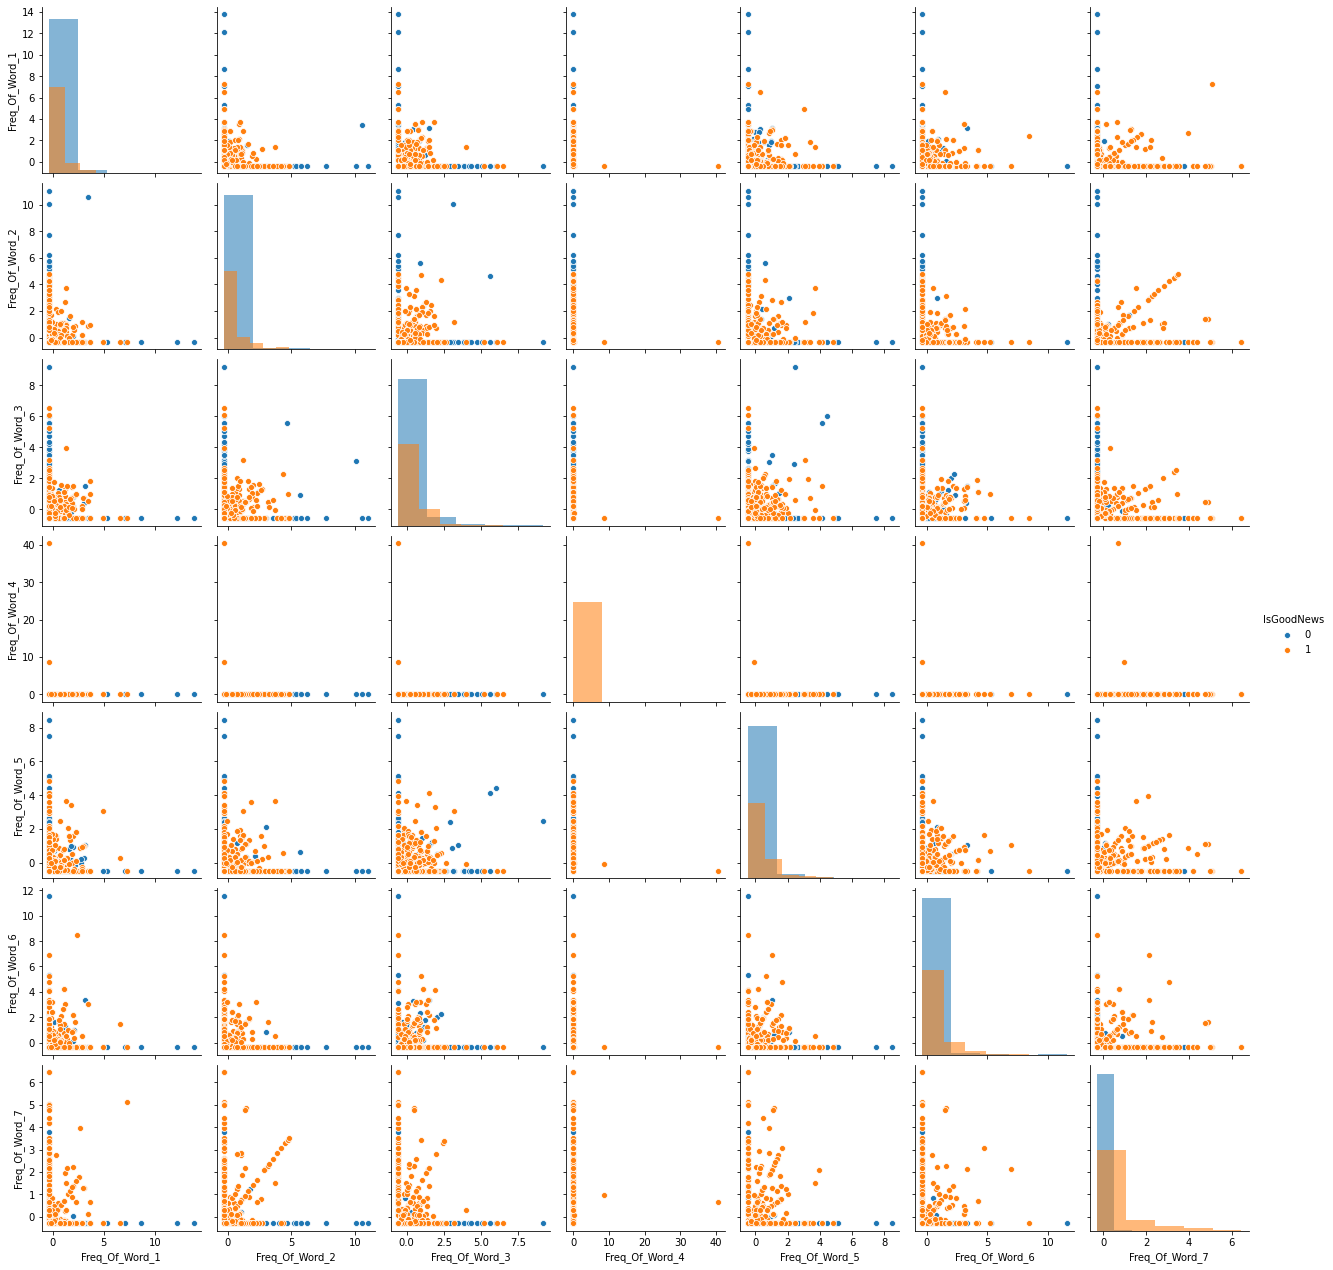

In [13]:
sns.pairplot(data=df_train[cols],diag_kind='hist',hue='IsGoodNews',diag_kws = {'alpha':0.55, 'bins':5})

In [ ]:
data = df_train[cols]
data = pd.melt(data,id_vars="IsGoodNews",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(15,10))
sns.swarmplot(x="features", y="value", hue="IsGoodNews", data=data)
plt.xticks(rotation=90)

Similarly I saw all the features then came to conclusion many of the features don't really show a good separation,
I also saw some kde plots and also some scatter plots and still not much luck

In [14]:
X_train,X_valid,y_train,y_valid = train_test_split(df_train.drop('IsGoodNews',axis=1),df_train['IsGoodNews'],
                                                   test_size=0.30,random_state=22,stratify=df_train['IsGoodNews'],shuffle=True)

In [15]:
cv = KFold(n_splits=5,random_state=22,shuffle=True)
# results = pd.DataFrame(columns='training_score', 'test_score')
score_avg = []
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    m = lgb.LGBMClassifier(random_state=22,n_estimators=100)
    m.fit(X_train.iloc[train],  y_train.iloc[train])
    score_avg.append(f1_score(y_pred=m.predict(X_train.iloc[test]),y_true=y_train.iloc[test]))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

          0
0  0.924528
1  0.934579
2  0.901961
3  0.878505
4  0.877551
0.9034248437516428


I manually tuned the hyperparmeters and got the final score.

You just had to trust your local cv in this competition , since the dataset was small i created features but they really didnt help me.


I also tried unormalising the dataset, tho its a hell lot of work to do you can try and get approximate values

In [16]:
y_final_preds = m.predict(df_test)
df_sub['IsGoodNews']= y_final_preds

In [17]:
df_sub.to_excel('first_sub_1.xlsx',index=False)